### DashForCash

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import duckdb

In [2]:
data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


#### preprocessing data

In [ ]:
# loading data

# standard CRSP exchange codes:
# 1 = NYSE
# 2 = AMEX
# 3 = NASDAQ
# 4 = NYSE Arca (includes SPY)
# 11 = NYSE MKT

con = duckdb.connect()

start_date = '1995-01-01'
end_date = '2024-01-01'

# Query:
# 1. join with delisting adjusted data
# 2. join with market data
# 3. filter by exchange
# 4. make sure the return is not null
query_data = (f"""
    SELECT 
    dsf.permno,
    dsf.dlycaldt AS date,
    dsf.dlyret AS ret,
    dsf.shrout AS shares_outstanding,
    (dsf.shrout * dsf.dlyprc) AS market_cap,
    mkt.mkt_rf,
    mkt.rf,
    (dsf.dlyret - mkt.rf) AS ret_rf
    FROM read_parquet('crsp_202401.dsf_v2.parquet') AS dsf 
    JOIN (
        SELECT permno, namedt, nameendt, hexcd AS exchange
        FROM read_parquet('crsp_202401.dsenames.parquet')
    ) AS dsenames
    ON dsf.permno = dsenames.permno
              
    /* Need to do date between namedt and nameendt */
    AND dsf.dlycaldt BETWEEN dsenames.namedt AND dsenames.nameendt
    
    JOIN (
        SELECT dt, mkt_rf, rf
        FROM read_parquet('ff.four_factor.parquet')
    ) AS mkt
    ON dsf.dlycaldt = mkt.dt
    WHERE dsf.dlycaldt BETWEEN '{start_date}' AND '{end_date}'
    AND dsenames.exchange IN (1, 2, 3)
    AND dsf.dlyret IS NOT NULL
""")

crsp_d = con.execute(query_data).fetch_df()
crsp_d['date'] = pd.to_datetime(crsp_d['date'])
con.close()
crsp_d

In [7]:
print(f'Number of unique permnos: {crsp_d["permno"].nunique()}')

Number of unique permnos: 22602


#### Run regressions to get beta - multi-process

In [8]:
# calculate the average of the rolling betas
def calc_rolling_beta(df: pd.DataFrame, window_size=60, step=1) -> dict:
    # use a rolling window approach with a fixed window size
    betas = {}
    
    for i in range(window_size, len(df), step):
        window_data = df.iloc[i - window_size:i]
        X = sm.add_constant(window_data['mkt_rf'])
        y = window_data['ret_rf']
        model = sm.OLS(y, X, missing='drop')
        results = model.fit()
        date_label = df.iloc[i]['date']
        betas[date_label] = results.params['mkt_rf']
         
    return betas

In [9]:
from joblib import Parallel, delayed
from tqdm import tqdm

# pre-filter groups with sufficient data
groups = [(permno, group) for permno, group in crsp_d.groupby('permno') if len(group) > 60]

# sort each group by date
groups = [(permno, group.sort_values(by='date')) for permno, group in groups]

def process_group(permno, group):
    return (permno, calc_rolling_beta(group))

# process in parallel with progress bar
results = Parallel(n_jobs=-1)(
    delayed(process_group)(permno, group) 
    for permno, group in tqdm(groups)
)

beta_dict = {permno: beta for permno, beta in results}

100%|██████████| 22329/22329 [35:22<00:00, 10.52it/s]


In [10]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient="index").stack().reset_index()
beta_df.columns = ["permno", "date", "beta"]

In [3]:
beta_df = pd.read_parquet('beta_df.parquet')
beta_df

,permno,date,beta
0,10001,1995-03-29,0.164138
1,10001,1995-03-30,0.250752
2,10001,1995-03-31,0.404727
3,10001,1995-04-03,0.418138
4,10001,1995-04-04,0.401360
...,...,...,...
47836116,24174,2023-12-29,1.231060
47836117,24175,2023-12-28,0.561101
47836118,24175,2023-12-29,-0.099663
47836119,24488,2023-12-28,1.721661


In [5]:
import duckdb
con = duckdb.connect()
crsp_beta_df = con.execute("""
SELECT crsp_d.*, beta_df.beta
FROM beta_df JOIN crsp_d
ON beta_df.permno = crsp_d.permno
AND beta_df.date = crsp_d.date
""").fetch_df()
con.close()

In [ ]:
# saving beta_df to a file
# crsp_beta_df.to_parquet('crsp_beta_df.parquet')

In [3]:
crsp_beta_df = pd.read_parquet('crsp_beta_df.parquet')
crsp_beta_df

,permno,date,ret,shares_outstanding,market_cap,mkt_rf,rf,ret_rf,beta
0,89159,2010-07-02,-0.002633,1969,29830.35,-0.0050,0.00001,-0.002643,0.196641
1,89159,2010-07-06,0.002640,1969,29909.11,0.0033,0.00001,0.002630,0.197079
2,89159,2010-07-07,-0.003292,1969,29810.66,0.0317,0.00001,-0.003302,0.196224
3,89159,2010-07-08,0.003963,1969,29928.80,0.0100,0.00001,0.003953,0.176956
4,89159,2010-07-09,0.001974,1969,29987.87,0.0081,0.00001,0.001964,0.178513
...,...,...,...,...,...,...,...,...,...
47836116,88205,2004-04-23,0.043307,78073,206893.45,-0.0001,0.00004,0.043267,2.226811
47836117,88205,2004-04-26,0.037736,78073,214700.75,-0.0033,0.00004,0.037696,2.302450
47836118,88205,2004-04-27,-0.025455,78073,209235.64,0.0013,0.00004,-0.025495,2.264021
47836119,88205,2004-04-28,-0.052239,78073,198305.42,-0.0146,0.00004,-0.052279,2.269387


#### Decile Long-Short Portfolio on Rolling-Beta

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import duckdb

data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


In [3]:
# Helper function to turn of the month identification
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values(['permno', 'date'])
    
    dates_labled = []
    
    dates_df = df.drop_duplicates(subset=['date'])[['date']].copy()
    dates_df['month'] = dates_df['date'].dt.to_period('M')

    # Initialize trading day labels
    dates_df['period_label'] = np.nan
    dates_df['period_label'] = dates_df['period_label'].astype(str)

    for month in tqdm(dates_df['month'].unique()):
        month_data = dates_df[dates_df['month'] == month]
        month_data.reset_index(drop=True, inplace=True)

        # handle corner cases: month data length not enough, cannot determine the trading day labels
        if len(month_data) < 10:
            continue
        # get around corner cases, where we don't have previous 8 days or next 8 days
        try:
            # start-of-month index in current month
            S_idx: int = month_data['date'].idxmin()
            # order matters, process 'T+1_T+4' first
            month_data.loc[list(range(S_idx, S_idx + 3)), 'period_label'] = 'T+1_T+3'
            month_data.loc[list(range(S_idx + 3, S_idx + 8)), 'period_label'] = 'T+4_T+8'
        except:
            pass

        try:
            # end-of-month index in current month
            T_idx: int = month_data['date'].idxmax()
            month_data.loc[T_idx, 'period_label'] = 'T'
            # order matters for the same reason
            month_data.loc[list(range(T_idx - 3, T_idx)), 'period_label'] = 'T-3_T-1'
            month_data.loc[list(range(T_idx - 8, T_idx - 3)), 'period_label'] = 'T-8_T-4'
        except:
            pass
            
        dates_labled.append(month_data)
            
    dates_labled_df = pd.concat(dates_labled, ignore_index=True)

    result_df = pd.merge(df, dates_labled_df[['date', 'period_label']], on='date', how='left')
    
    return result_df

In [4]:
# Helper function from Alan
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [5]:
crsp_beta_df = pd.read_parquet('crsp_beta_df.parquet')
crsp_beta_df = crsp_beta_df.sort_values(['permno', 'date'])

In [8]:
crsp_beta_df = label_trading_days(crsp_beta_df)

100%|██████████| 346/346 [00:00<00:00, 668.10it/s]


In [9]:
# lag the market cap, using market cap value of the previous month last trading day
# also, drop null period_label
con = duckdb.connect()
con.execute(
"""
  WITH month_end AS (
      SELECT permno, LAST_DAY(LAST(date)) AS month_end_date,
      LAST(market_cap) AS mcap_lag
      FROM crsp_beta_df
      WHERE period_label IS NOT NULL
      AND market_cap IS NOT NULL
      GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
  )
  SELECT crsp_beta_df.*, month_end.mcap_lag as mcap_lag
  FROM crsp_beta_df LEFT JOIN month_end
  ON crsp_beta_df.permno = month_end.permno
  AND month_end.month_end_date = LAST_DAY(crsp_beta_df.date - INTERVAL 1 MONTH)
  WHERE period_label IS NOT NULL
  AND period_label NOT LIKE '%nan%'
"""
)
crsp_beta_df = con.fetch_df()
con.close()
crsp_beta_df

,permno,date,ret,shares_outstanding,market_cap,mkt_rf,rf,ret_rf,beta,period_label,mcap_lag
0,10574,1999-03-29,0.000000,8443,12136.8125,0.0198,0.00018,-0.000180,-0.336986,T-3_T-1,13719.8750
1,10574,1999-03-30,0.043478,8443,12664.5000,-0.0063,0.00018,0.043298,-0.327997,T-3_T-1,13719.8750
2,10574,1999-03-31,0.041667,8443,13192.1875,-0.0086,0.00018,0.041487,-0.481272,T,13719.8750
3,10574,1999-04-01,-0.040000,8443,12664.5000,0.0054,0.00018,-0.040180,-0.520913,T+1_T+3,12136.8125
4,10574,1999-04-05,0.000000,8443,12664.5000,0.0187,0.00018,-0.000180,-0.545666,T+1_T+3,12136.8125
...,...,...,...,...,...,...,...,...,...,...,...
38730210,93427,2010-09-24,0.056769,33752,490079.0400,0.0219,0.00001,0.056759,0.510030,T-8_T-4,NaN
38730211,93427,2010-09-27,0.077824,33752,528218.8000,-0.0046,0.00001,0.077814,0.597168,T-3_T-1,NaN
38730212,93427,2010-09-28,0.003195,33752,529906.4000,0.0058,0.00001,0.003185,0.537482,T-3_T-1,NaN
38730213,93427,2010-09-29,-0.015287,33752,521805.9200,-0.0017,0.00001,-0.015297,0.538693,T-3_T-1,NaN


In [10]:
from tqdm import tqdm

def apply_group_quantiles(group, col, bins=10):
    group['bin'] = apply_quantiles(group, col, bins=bins)
    return group

crsp_beta_df['month'] = crsp_beta_df['date'].dt.to_period('M')
tqdm.pandas(desc="Applying quantiles")

# want to assign quantiles within each day
crsp_beta_df = crsp_beta_df.groupby('date').progress_apply(lambda group: apply_group_quantiles(group, 'beta', bins=10)).reset_index(drop=True)

Applying quantiles: 100%|██████████| 5863/5863 [00:45<00:00, 127.74it/s]


In [11]:
daily_bins = crsp_beta_df.groupby(['period_label', 'date', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['ret'].mean(),
        'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
    })
).reset_index()

# calculate the average return for each bin
bins = daily_bins.groupby(['period_label', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

/tmp/ipykernel_3254801/4184700901.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3254801/4184700901.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_bins = crsp_beta_df.groupby(['period_label', 'date', 'bin']).apply(
/tmp/ipykernel_3254801/4184700901.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bi

In [12]:
import matplotlib.pyplot as plt

def plot_bins(bins_df, column, label, width = 0.35):
  plt.figure(figsize=(10, 6))  # Adjust the size as needed
  day_data = bins_df[bins_df[column] == label]
  x = np.arange(len(day_data))  # Ensure x is a simple range of integers

  fig, ax = plt.subplots()

  # Plot the bars
  ax.bar(x - width/2, day_data['VW'], width, alpha=0.7, label='VW')
  ax.bar(x + width/2, day_data['EW'], width, alpha=0.7, label='EW')

  # Simplify the plot
  ax.set_xticks(x)
  ax.set_xticklabels(day_data['bin'].astype(str))  # Ensure proper x-tick labels
  ax.set_xlabel('Bin')
  ax.set_ylabel('Returns')
  ax.set_title(f'Trading Day {label}')
  ax.legend()

  plt.show()

##### All sample period: from 1995-01-01 to 2024-01-01

<Figure size 1000x600 with 0 Axes>

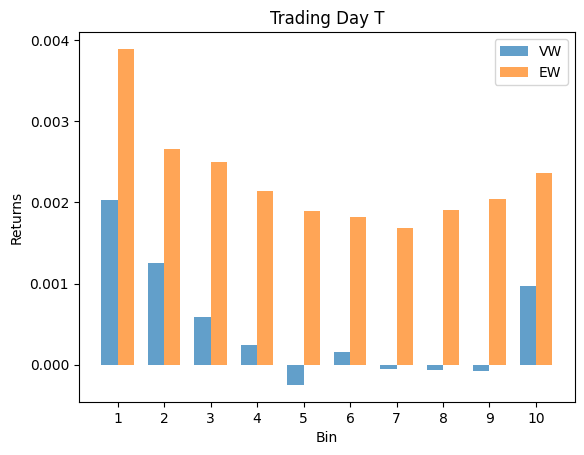

<Figure size 1000x600 with 0 Axes>

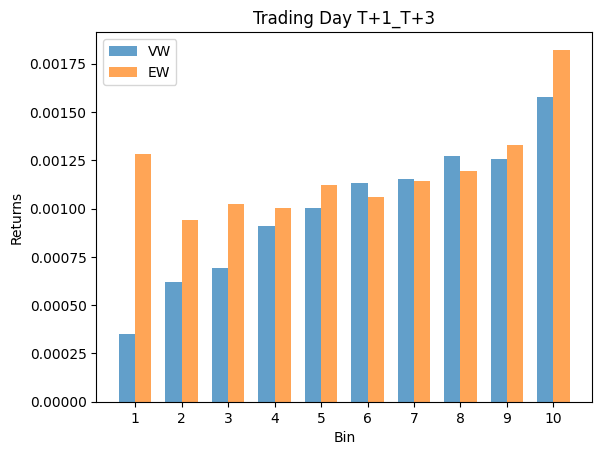

<Figure size 1000x600 with 0 Axes>

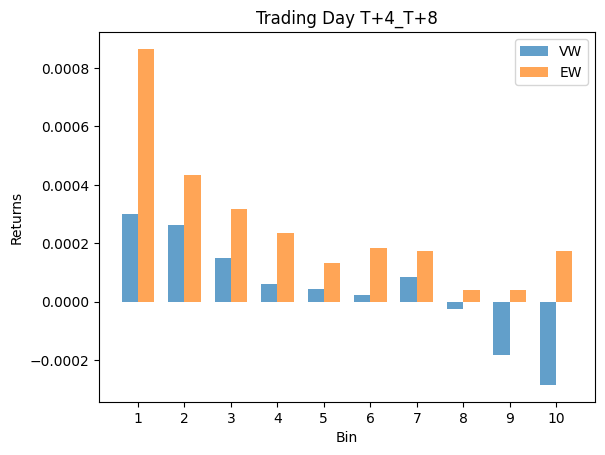

<Figure size 1000x600 with 0 Axes>

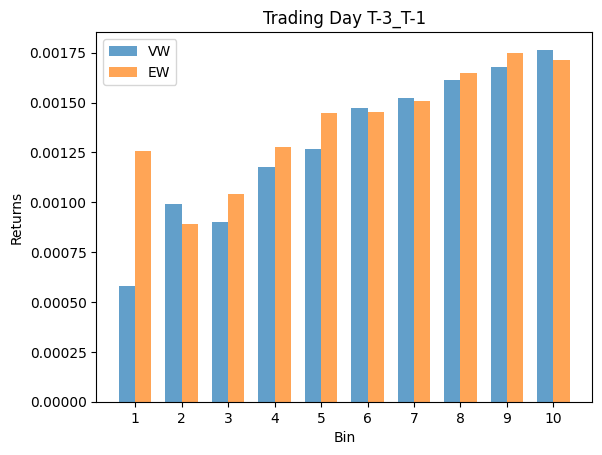

<Figure size 1000x600 with 0 Axes>

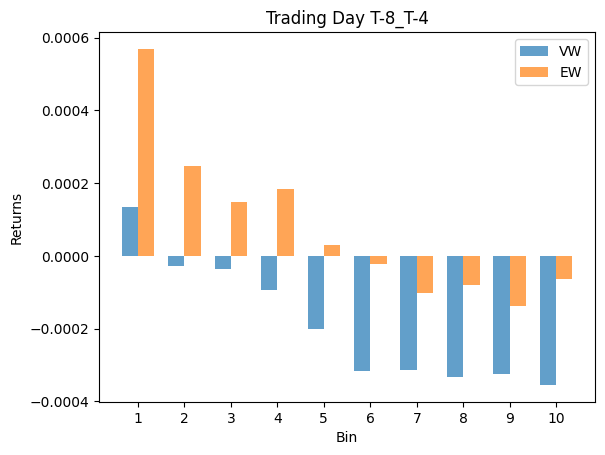

In [28]:
# Plot each trading period bins
for i, label in enumerate(bins['period_label'].unique(), 1):
    plot_bins(bins, 'period_label', label)

##### In-sample period: from 1995-01-01 to 2013-12-31

In [13]:
def plot_bins_period(daily_bins_df, start_date, end_date):
    # calculate the average return for each bin
    bins = daily_bins_df[daily_bins_df['date'].between(start_date, end_date)].groupby(['period_label', 'bin']).apply(
        lambda g: pd.Series({
            'EW': g['EW'].mean(),
            'VW': g['VW'].mean()
        })
    ).reset_index()

    for i, label in enumerate(bins['period_label'].unique(), 1):
        plot_bins(bins, 'period_label', label)

/tmp/ipykernel_3254801/934255859.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = daily_bins_df[daily_bins_df['date'].between(start_date, end_date)].groupby(['period_label', 'bin']).apply(


<Figure size 1000x600 with 0 Axes>

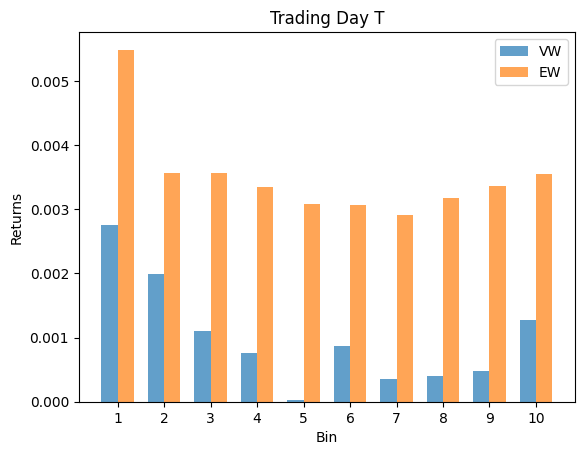

<Figure size 1000x600 with 0 Axes>

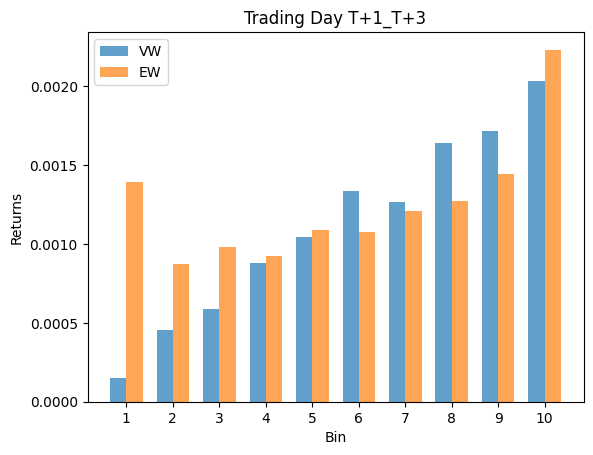

<Figure size 1000x600 with 0 Axes>

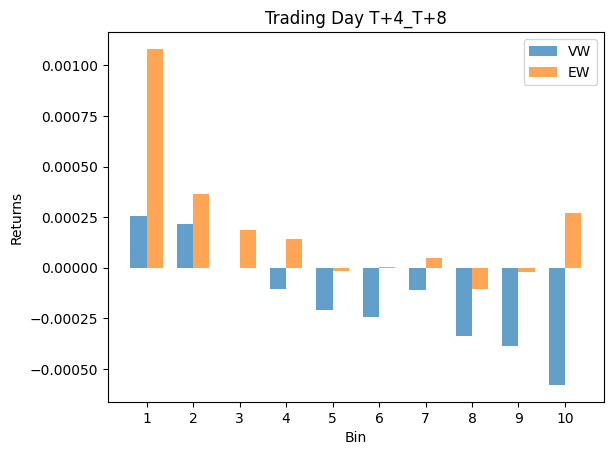

<Figure size 1000x600 with 0 Axes>

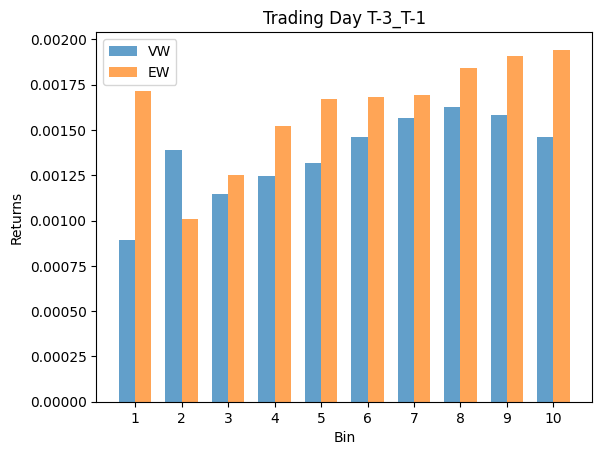

<Figure size 1000x600 with 0 Axes>

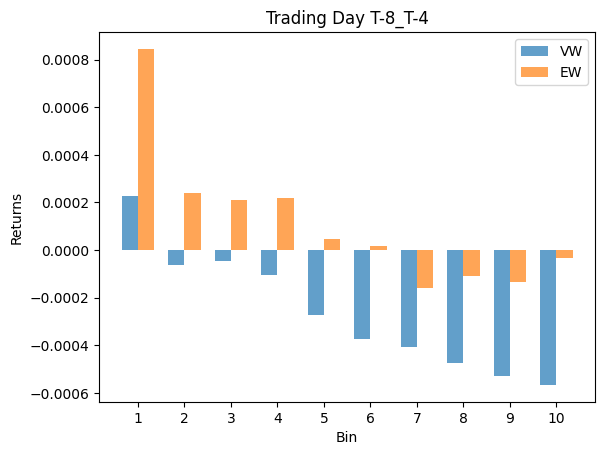

In [14]:
plot_bins_period(daily_bins, '1995-01-01', '2013-12-31')

##### Out-of-Sample period: from 2014-01-01 to 2023-12-31

/tmp/ipykernel_3210689/431783915.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = daily_bins_df[daily_bins_df['date'].between(start_date, end_date)].groupby(['period_label', 'bin']).apply(


<Figure size 1000x600 with 0 Axes>

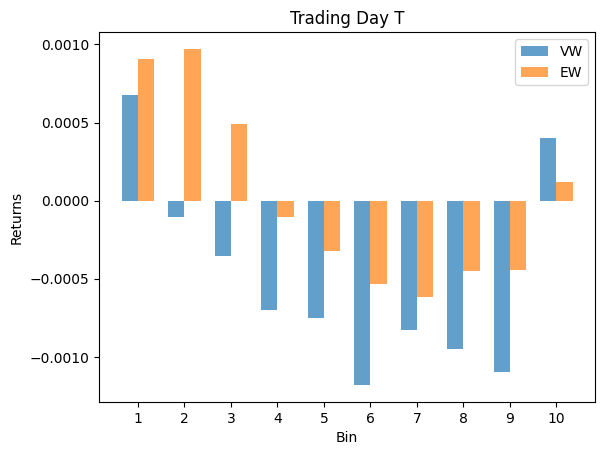

<Figure size 1000x600 with 0 Axes>

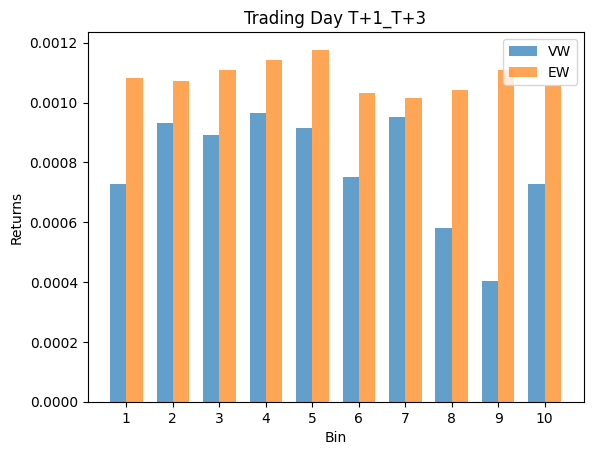

<Figure size 1000x600 with 0 Axes>

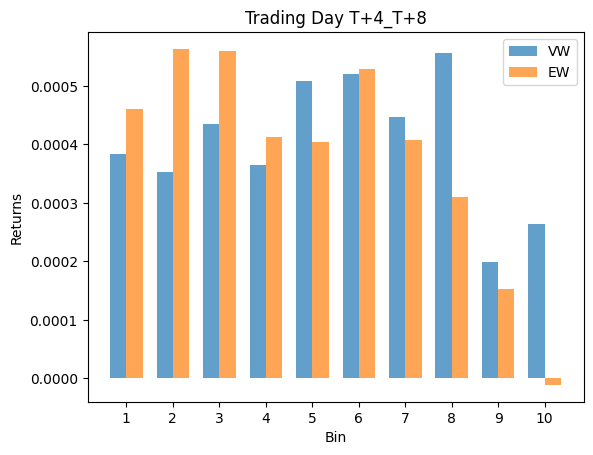

<Figure size 1000x600 with 0 Axes>

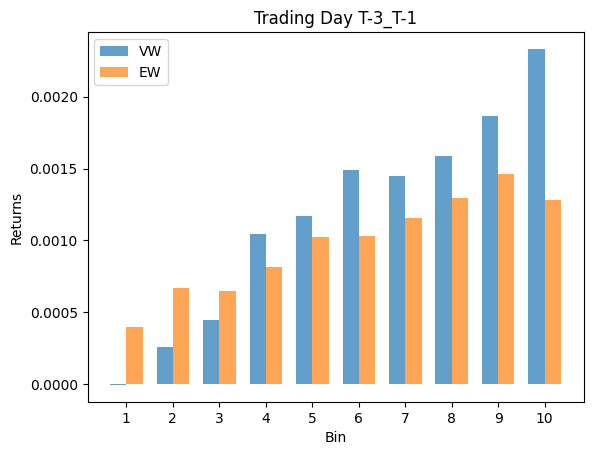

<Figure size 1000x600 with 0 Axes>

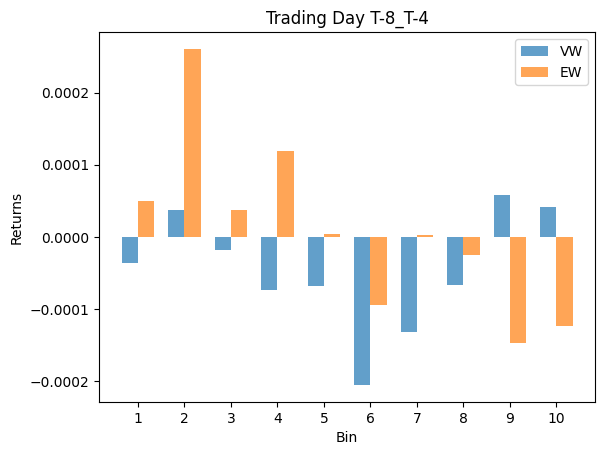

In [31]:
plot_bins_period(daily_bins, '2014-01-01', '2023-12-31')

#### Correlation Analysis (full-sample)

Correlation analysis on time-series returns between (selling pressure, positive reversal) pair, and (buying pressure, negative reversal) pair.

In [35]:
crsp_beta_df.groupby(['month', 'period_label', 'bin']).apply(
  lambda g: pd.Series({
    'EW': g['ret'].mean(),
    'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
  })
).reset_index().groupby('bin').apply(
  lambda g: pd.Series({
    'EW_T+1_T+3_T+4_T+8': g.pivot(index='month', columns='period_label', values='EW').corr().loc['T+1_T+3', 'T+4_T+8'],
    'EW_T-8_T-4_T-3_T-1': g.pivot(index='month', columns='period_label', values='EW').corr().loc['T-8_T-4', 'T-3_T-1'],
    'VW_T+1_T+3_T+4_T+8': g.pivot(index='month', columns='period_label', values='VW').corr().loc['T+1_T+3', 'T+4_T+8'],
    'VW_T-8_T-4_T-3_T-1': g.pivot(index='month', columns='period_label', values='VW').corr().loc['T-8_T-4', 'T-3_T-1'],
  })
)

/tmp/ipykernel_3210689/1687214008.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3210689/1687214008.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_beta_df.groupby(['month', 'period_label', 'bin']).apply(
/tmp/ipykernel_3210689/1687214008.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).reset_index(

,EW_T+1_T+3_T+4_T+8,EW_T-8_T-4_T-3_T-1,VW_T+1_T+3_T+4_T+8,VW_T-8_T-4_T-3_T-1
bin,,,,
1,0.405974,0.098225,0.262965,-0.177540
2,0.204329,0.043268,-0.008280,-0.260076
3,0.135229,-0.103555,-0.118854,-0.245575
4,0.123179,-0.178101,0.011192,-0.235495
5,0.092766,-0.180504,-0.016947,-0.233350
6,0.079267,-0.223194,-0.002861,-0.280085
7,0.056507,-0.214409,0.007640,-0.292909
8,0.056626,-0.230027,-0.022743,-0.337858
9,0.070496,-0.227663,-0.006566,-0.278949


#### Building a Portfolio - Long high-beta Short low-beta

In [42]:
# label trading_period as T-3 to T+3, where there exists positive reversal and buying pressure
daily_bins['trading_period'] = daily_bins['period_label'].isin(["T-3_T-1", "T", "T+1_T+3"])

/tmp/ipykernel_3210689/928762280.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = daily_bins.groupby(['trading_period', 'bin']).apply(


<Figure size 1000x600 with 0 Axes>

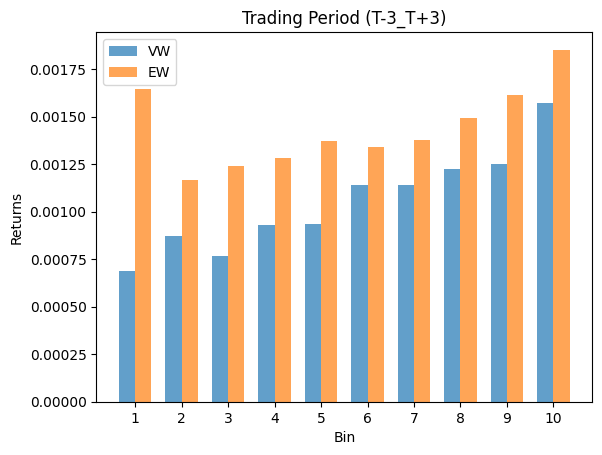

In [ ]:
bins = daily_bins.groupby(['trading_period', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

width = 0.35

plt.figure(figsize=(10, 6))
day_data = bins[bins['trading_period']]
x = np.arange(len(day_data))

fig, ax = plt.subplots()

# Plot the bars
ax.bar(x - width/2, day_data['VW'], width, alpha=0.7, label='VW')
ax.bar(x + width/2, day_data['EW'], width, alpha=0.7, label='EW')

# Simplify the plot
ax.set_xticks(x)
ax.set_xticklabels(day_data['bin'].astype(str))  # Ensure proper x-tick labels
ax.set_xlabel('Bin')
ax.set_ylabel('Returns')
ax.set_title(f'Trading Period (T-3_T+3)')
ax.legend()

plt.show()

In [106]:
portfolio_trading_period = pd.merge(
    daily_bins.query('trading_period & bin == 10'),
    daily_bins.query('trading_period & bin == 1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolio_trading_period['long_short_EW'] = portfolio_trading_period['EW_long'] - portfolio_trading_period['EW_short']
portfolio_trading_period['long_short_VW'] = portfolio_trading_period['VW_long'] - portfolio_trading_period['VW_short']
portfolio_trading_period['cumulative_ret_EW'] = (1 + portfolio_trading_period['long_short_EW']).cumprod() - 1
portfolio_trading_period['cumulative_ret_VW'] = (1 + portfolio_trading_period['long_short_VW']).cumprod() - 1

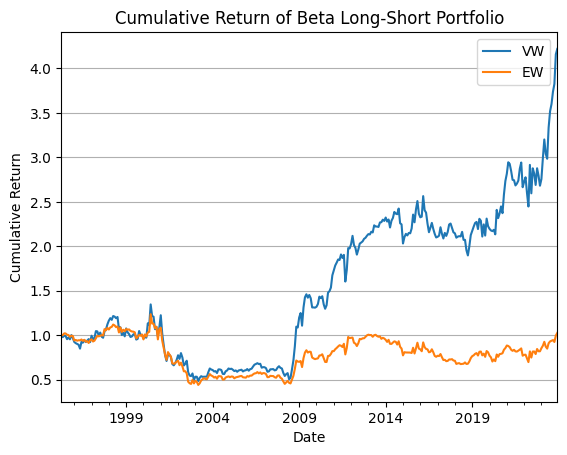

In [129]:
(
  (portfolio_trading_period
   .set_index('date')[['long_short_VW', 'long_short_EW']]+1)
   .rename(columns={'long_short_EW': 'EW', 'long_short_VW': 'VW'})
   .resample('ME').prod().cumprod().plot().grid(axis='y')
)

plt.title('Cumulative Return of Beta Long-Short Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

### Long-Short Divident Payer Portfolio

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import duckdb

data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


In [2]:
# loading data

# standard CRSP exchange codes:
# 1 = NYSE
# 2 = AMEX
# 3 = NASDAQ
# 4 = NYSE Arca (includes SPY)
# 11 = NYSE MKT

con = duckdb.connect()

start_date = '1995-01-01'
end_date = '2024-01-01'

# Query:
# 1. join with delisting adjusted data
# 2. join with market data
# 3. filter by exchange
# 4. make sure the return is not null
query_data = (f"""
    SELECT 
    dsf.permno,
    dlycaldt  AS date,
    dlyret    AS ret,
    dlyorddivamt as div_amount,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    FROM read_parquet('crsp_202401.dsf_v2.parquet') AS dsf 
    JOIN (
        SELECT *, hexcd AS exchange
        FROM read_parquet('crsp_202401.dsenames.parquet')
    ) AS dsenames
    ON dsf.permno = dsenames.permno
              
    /* Need to do date between nametd and nameetd*/
    WHERE dlycaldt BETWEEN namedt AND nameendt
    
    /* Other conditions imposed */
    AND dlycaldt BETWEEN '{start_date}' AND '{end_date}'
    AND exchange IN (1, 2, 3)
    AND dsf.dlyret IS NOT NULL
""")

crsp_df = con.execute(query_data).fetch_df()
crsp_df['date'] = pd.to_datetime(crsp_df['date'])
crsp_df = crsp_df.sort_values(['permno', 'date'])
crsp_df = crsp_df.reset_index(drop=True)
con.close()
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap
0,10001,1995-01-03,0.046875,0.0,2224,1.862600e+04
1,10001,1995-01-04,-0.044776,0.0,2224,1.779200e+04
2,10001,1995-01-05,-0.062500,0.0,2224,1.668000e+04
3,10001,1995-01-06,0.033333,0.0,2224,1.723600e+04
4,10001,1995-01-09,-0.032258,0.0,2224,1.668000e+04
...,...,...,...,...,...,...
49183691,93436,2023-12-22,-0.007701,0.0,3178921,8.028047e+08
49183692,93436,2023-12-26,0.016116,0.0,3178921,8.157429e+08
49183693,93436,2023-12-27,0.018822,0.0,3178921,8.310971e+08
49183694,93436,2023-12-28,-0.031594,0.0,3178921,8.048392e+08


In [5]:
crsp_df = label_trading_days(crsp_df)

100%|██████████| 348/348 [00:00<00:00, 671.09it/s]


In [6]:
# which stocks pays monthly dividends?
con = duckdb.connect()
con.execute(f"""
    SELECT permno, COUNT(*) AS num_dividends
    FROM crsp_df
    WHERE div_amount > 0.00001
    GROUP BY permno
    ORDER BY permno
""").fetch_df()

,permno,num_dividends
0,10001,137
1,10002,59
2,10009,23
3,10019,2
4,10025,7
...,...,...
9282,93415,54
9283,93416,83
9284,93419,52
9285,93422,25


Now we want to create a new column in the dataframe: 'div_lag'. What this column does is that it will look back 1-year time window, and find the most recent dividend payment amount. If there is no dividend payment in the past year, then the value is 0

In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

# Calculate div_lag
def calculate_div_lag(group):
    group['div_lag'] = group['div_amount'].shift().rolling(window=252, min_periods=1).apply(lambda x: x[x != 0].max() if not x[x != 0].empty else 0)
    group['div_lag'] = group['div_lag'].fillna(0)
    return group

# Function to apply calculate_div_lag to each group
def process_group(name, group):
    return calculate_div_lag(group)

# Split the DataFrame by 'permno' and process each group in parallel
permno_groups = list(crsp_df.groupby('permno'))
results = Parallel(n_jobs=-1)(delayed(process_group)(name, group) for name, group in tqdm(permno_groups, desc="Calculating div_lag"))

# Combine the results back into a single DataFrame
crsp_df = pd.concat(results).reset_index(drop=True)

Calculating div_lag: 100%|██████████| 22602/22602 [04:57<00:00, 75.98it/s]


In [8]:
crsp_df.to_parquet('crsp_div_lag.parquet')

In [12]:
# check out the percentage of non-div paying stock each month
crsp_df['month'] = crsp_df['date'].dt.to_period('M')
crsp_df.groupby(['month']).apply(
  lambda g: pd.Series({
    'percent_zero_div': (g['div_lag'] == 0).sum() / len(g) * 100,
  })
).reset_index().round({'percent_zero_div': 2})

/tmp/ipykernel_3244791/2169642181.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_df.groupby(['month']).apply(


,month,percent_zero_div
0,1995-01,94.48
1,1995-02,82.84
2,1995-03,70.63
3,1995-04,63.15
4,1995-05,62.11
...,...,...
343,2023-08,56.90
344,2023-09,56.76
345,2023-10,56.50
346,2023-11,56.36


In [9]:
# lag the market cap, using market cap value of the previous month last trading day
con = duckdb.connect()
con.execute(
"""
  WITH month_end AS (
    SELECT permno, LAST_DAY(LAST(date)) AS month_end_date,
    LAST(market_cap) AS mcap_lag
    FROM crsp_df
    WHERE period_label IS NOT NULL
    AND market_cap IS NOT NULL
    GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
  )
  SELECT crsp_df.*, month_end.mcap_lag as mcap_lag
  FROM crsp_df LEFT JOIN month_end
  ON crsp_df.permno = month_end.permno
  AND month_end.month_end_date = LAST_DAY(crsp_df.date - INTERVAL 1 MONTH)
  WHERE period_label IS NOT NULL
  AND period_label NOT LIKE '%nan%'
"""
)
crsp_df = con.fetch_df()
con.close()
crsp_df

,permno,date,ret,div_amount,shares_outstanding,market_cap,period_label,div_lag,mcap_lag
0,10659,2006-08-31,0.067140,0.0,13077,295147.89,T,0.0,307963.35
1,10659,2006-09-01,-0.007089,0.0,13077,293055.57,T+1_T+3,0.0,276578.55
2,10659,2006-09-05,0.001339,0.0,13083,293582.52,T+1_T+3,0.0,276578.55
3,10659,2006-09-06,-0.011141,0.0,13083,290311.77,T+1_T+3,0.0,276578.55
4,10659,2006-09-07,0.020279,0.0,13083,296199.12,T+4_T+8,0.0,276578.55
...,...,...,...,...,...,...,...,...,...
39839855,92945,2009-06-24,0.000000,0.0,16768,198533.12,T-8_T-4,0.0,NaN
39839856,92945,2009-06-25,0.003378,0.0,16768,199203.84,T-3_T-1,0.0,NaN
39839857,92945,2009-06-26,0.000842,0.0,16768,199371.52,T-3_T-1,0.0,NaN
39839858,92945,2009-06-29,-0.003364,0.0,16768,198700.80,T-3_T-1,0.0,NaN


In [ ]:
from tqdm import tqdm

# calssify dividend-paying permnos and non-dividend-paying permnos
def apply_div_labels(group):
    # assign div_label to be that: if div_lag is not zero then 1, else 0
    group['bin'] = (group['div_lag'] != 0).astype(int)
    return group

tqdm.pandas(desc="Applying quantiles")

crsp_df = crsp_df.groupby('date').progress_apply(lambda group: apply_div_labels(group)).reset_index(drop=True)

Applying quantiles: 100%|██████████| 5914/5914 [00:32<00:00, 183.58it/s] 


In [13]:
daily_bins = crsp_df.groupby(['period_label', 'date', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['ret'].mean(),
        'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
    })
).reset_index()

bins = daily_bins.groupby(['period_label', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

/tmp/ipykernel_3244791/1223721041.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3244791/1223721041.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_bins = crsp_df.groupby(['period_label', 'date', 'bin']).apply(
/tmp/ipykernel_3244791/1223721041.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = 

#### Full sample

/tmp/ipykernel_3244791/1134185225.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = daily_bins_df[daily_bins_df['date'].between(start_date, end_date)].groupby(['period_label', 'bin']).apply(


<Figure size 1000x600 with 0 Axes>

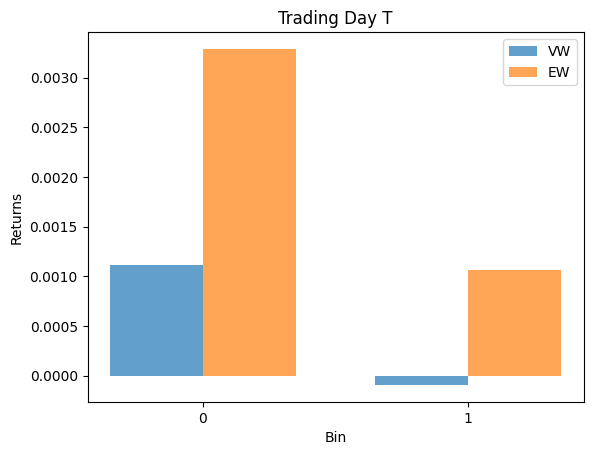

<Figure size 1000x600 with 0 Axes>

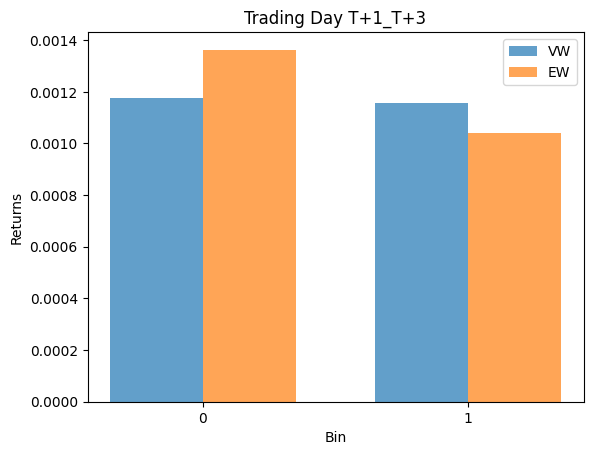

<Figure size 1000x600 with 0 Axes>

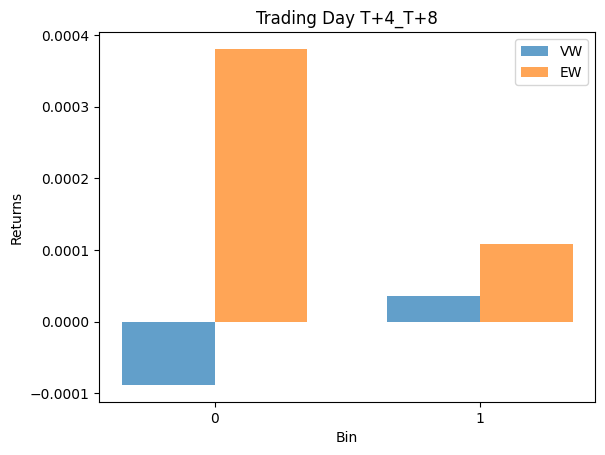

<Figure size 1000x600 with 0 Axes>

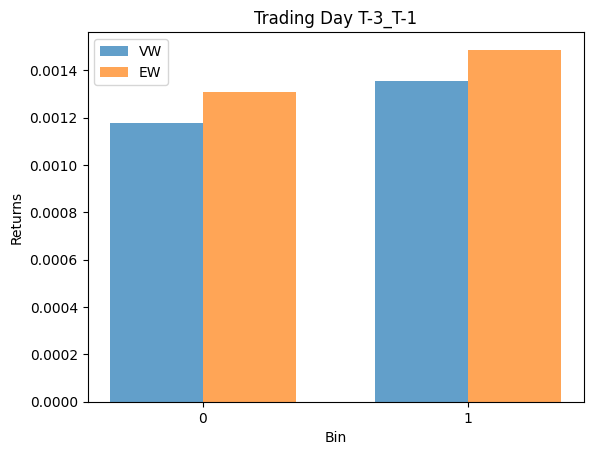

<Figure size 1000x600 with 0 Axes>

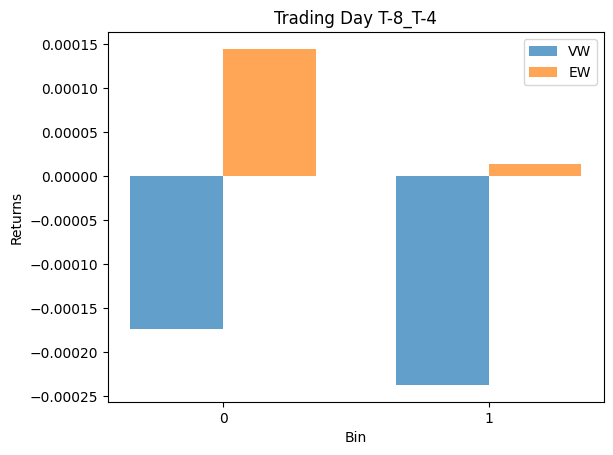

In [18]:
plot_bins_period(daily_bins, '1995-01-01', '2023-12-31')

In [19]:
daily_bins['trading_period'] = daily_bins['period_label'].isin(["T-3_T-1", "T", "T+1_T+3"])

/tmp/ipykernel_3244791/928762280.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = daily_bins.groupby(['trading_period', 'bin']).apply(


<Figure size 1000x600 with 0 Axes>

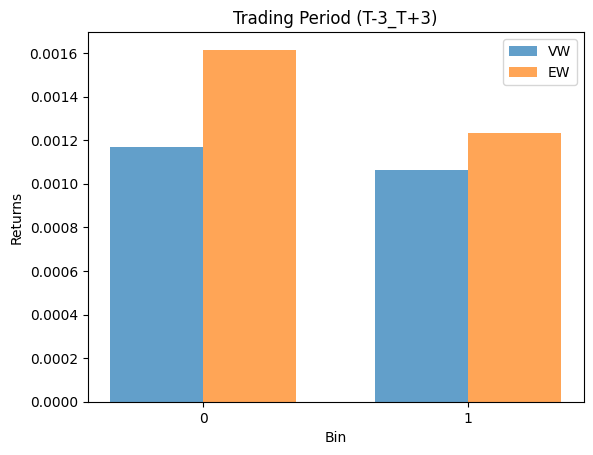

In [20]:
bins = daily_bins.groupby(['trading_period', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

width = 0.35

plt.figure(figsize=(10, 6))
day_data = bins[bins['trading_period']]
x = np.arange(len(day_data))

fig, ax = plt.subplots()

# Plot the bars
ax.bar(x - width/2, day_data['VW'], width, alpha=0.7, label='VW')
ax.bar(x + width/2, day_data['EW'], width, alpha=0.7, label='EW')

# Simplify the plot
ax.set_xticks(x)
ax.set_xticklabels(day_data['bin'].astype(str))  # Ensure proper x-tick labels
ax.set_xlabel('Bin')
ax.set_ylabel('Returns')
ax.set_title(f'Trading Period (T-3_T+3)')
ax.legend()

plt.show()

We want to long non-dividend-paying stocks and short dividend-paying stocks

In [25]:
portfolio_trading_period = pd.merge(
    daily_bins.query('trading_period & bin == 0'),
    daily_bins.query('trading_period & bin == 1'),
    suffixes=['_long', '_short'],
    on='date'
)

portfolio_trading_period['long_short_EW'] = portfolio_trading_period['EW_long'] - portfolio_trading_period['EW_short']
portfolio_trading_period['long_short_VW'] = portfolio_trading_period['VW_long'] - portfolio_trading_period['VW_short']
portfolio_trading_period['cumulative_ret_EW'] = (1 + portfolio_trading_period['long_short_EW']).cumprod() - 1
portfolio_trading_period['cumulative_ret_VW'] = (1 + portfolio_trading_period['long_short_VW']).cumprod() - 1

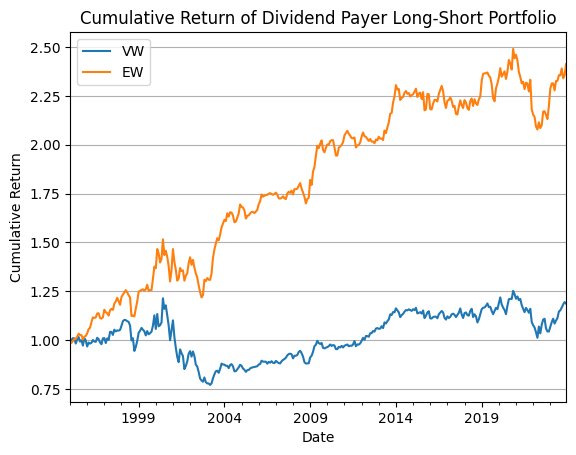

In [26]:
(
  (portfolio_trading_period
   .set_index('date')[['long_short_VW', 'long_short_EW']]+1)
   .rename(columns={'long_short_EW': 'EW', 'long_short_VW': 'VW'})
   .resample('ME').prod().cumprod().plot().grid(axis='y')
)

plt.title('Cumulative Return of Dividend Payer Long-Short Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()